In [1]:
# Importing all dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 4: Data pre-processing

In [2]:
# Loading the data
df = pd.read_csv('results.txt')
df.columns = ['id', 'num', 'image', 'label', 'time']
df.drop(["num"], axis=1, inplace=True)

# Removal of outliers
df.drop(df[df['time'] < 0.2].index, inplace=True)
df.drop(df[df['time'] > 3].index, inplace=True)

# Normalization of reaction times for each person
df['mean'] = df.groupby('id')['time'].transform('mean')
df['standard deviation'] = df.groupby('id')['time'].transform('std')

df['normalized'] = (df['time']-df['mean']) / df['standard deviation']
df['normalized scaled'] = (df['normalized']-df['normalized'].min()) / (df['normalized'].max() - df['normalized'].min())

df['score'] = 1 - df['normalized scaled']
df['score'][df['label'] == "Not smiling"] = df['normalized scaled'] -1

#df['min'] = df.groupby('id')['time'].transform('min')
#df['max'] = df.groupby('id')['time'].transform('max')
#df['normalized'] = (df['time']-df['min']) / (2*(df['max'] - df['min']))
#df['SmileNorm'] = 1-df['normalized']

df.head()

<ipython-input-2-7b23bafcbcf5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'][df['label'] == "Not smiling"] = df['normalized scaled'] -1


,id,image,label,time,mean,standard deviation,normalized,normalized scaled,score
0,7,55_1_0_20170103183939755.jpg.chip.jpg,Smiling,0.7776,0.826893,0.291417,-0.169149,0.157834,0.842166
1,7,42_1_0_20170105173320357.jpg.chip.jpg,Smiling,0.5956,0.826893,0.291417,-0.793685,0.087843,0.912157
2,7,26_1_1_20170112205848764.jpg.chip.jpg,Smiling,0.6308,0.826893,0.291417,-0.672896,0.101380,0.898620
3,7,28_0_3_20170113153014880.jpg.chip.jpg,Not smiling,0.6131,0.826893,0.291417,-0.733633,0.094573,-0.905427
4,7,50_0_0_20170113184603160.jpg.chip.jpg,Not smiling,0.7651,0.826893,0.291417,-0.212043,0.153027,-0.846973


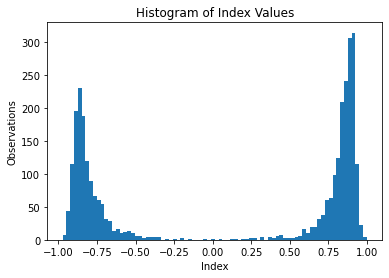

In [3]:
# Plotting histogram of index values
plt.title('Histogram of Index Values')
plt.hist(df['score'], bins = 80)
plt.xlabel('Index')
plt.ylabel('Observations')
plt.savefig('index histogram.png', dpi = 300, bbox_inches='tight')

# 5: PCA

In [4]:
# Loading the images
images = [cv2.imread(file) for file in glob.glob("SampledPhotos/*.jpg.chip.jpg")]
image_names = [str(file).split('\\')[1] for file in glob.glob("SampledPhotos/*.jpg.chip.jpg")]
im = np.array(images)

print(f"There are {len(images)} images in our dataset, and the shape of our images are {images[0].shape}")

There are 398 images in our dataset, and the shape of our images are (200, 200, 3)


In [5]:
# Convert images to 1D arrays, and combine all images in one 2D array
big_im = np.zeros([120000,len(images)])
for i in range(len(images)):
    big_im[:,i] = images[i].reshape(120000)

# Get the means of each pixel and subtract mean from every image
means = np.mean(big_im, axis=1)
subtracted_mean = (big_im.T - means).T

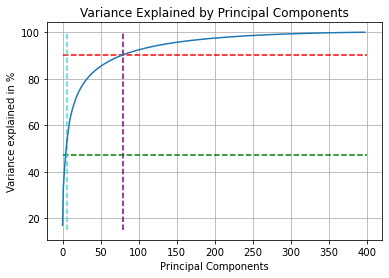

In [6]:
# run pca
pca = PCA()
S = pca.fit_transform(subtracted_mean)

# plot variance of PCA components
variance = pca.explained_variance_ratio_

plt.grid()
plt.plot(np.cumsum(variance)*100)
plt.hlines(90, 0, 400, colors='red', linestyles='dashed')
plt.vlines(79, 15, 100, colors='purple', linestyles='dashed')
plt.hlines(47.36, 0, 400, colors='green', linestyles='dashed')
plt.vlines(6, 15, 100, colors='turquoise', linestyles='dashed')
plt.title('Variance Explained by Principal Components')
plt.ylabel('Variance explained in %')
plt.xlabel('Principal Components')
plt.savefig('Variance explained.png', dpi = 300, bbox_inches='tight')

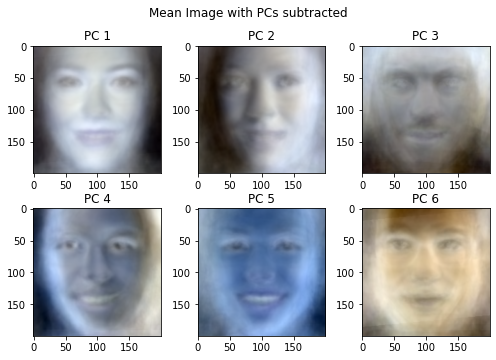

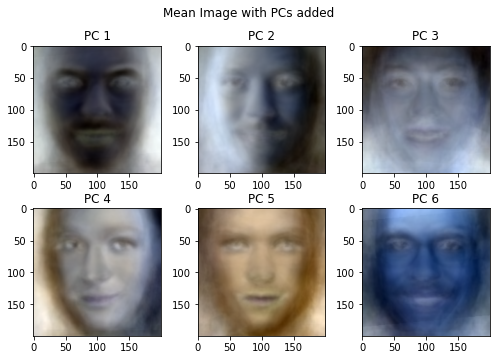

In [7]:
# Convert the components to 200x200x3 image shapes, and plot the first 10
pca_im = S[:,0].reshape([200,200,3])
pca_ims = S.reshape([200,200,3,len(images)])
pca_sub = ((means - S.T).T).reshape([200,200,3,len(images)])
pca_add = ((means + S.T).T).reshape([200,200,3,len(images)])
    
fig = plt.figure(figsize=(7,5))
fig.suptitle('Mean Image with PCs subtracted')
columns = 3
rows = 2
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img = pca_sub[:,:,:,i]
    # We find the max pixel value and divide by that so the image can be better visualized
    img = (img-np.amin(img)) / (np.amax(img)-np.amin(img))
    plt.imshow(img)
    plt.title('PC '+str(i+1))
   
plt.tight_layout()
plt.show()
fig.savefig('Scaled PCs subtracted.png', dpi = 650, bbox_inches='tight')

fig = plt.figure(figsize=(7,5))
fig.suptitle('Mean Image with PCs added')
columns = 3
rows = 2
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img = pca_add[:,:,:,i]
    # We find the max pixel value and divide by that so the image can be better visualized
    img = (img-np.amin(img)) / (np.amax(img)-np.amin(img))
    plt.imshow(img)
    plt.title('PC '+str(i+1))
   
plt.tight_layout()
plt.show()
fig.savefig('Scaled PCs added.png', dpi = 650, bbox_inches='tight')

# 6 & 7: Feature Selection and Linear Regression Model

Before we start with the feature selection and linear resression model, we first need to make a new dataframe. This dataframe will contain each image, all the scores for the images, and the average score for each image. We will then use this dataframe, as well as the loaded images from the previous section, to create our X and y data. Finally we split it up into train and test sets using an 80/20 ratio, and then apply PCA on them.

In [8]:
# Create a new dataframe with all the image names
df2 = pd.DataFrame(image_names)
df2.columns = (["image"])

# Add the scores for each person to the dataframe
count = 1
for i in df.groupby("id"):
    grouped_df = i[1][["image","score"]]
    grouped_df.columns = ['image', 'score'+str(count)]
    df2 = pd.merge(df2, grouped_df,how="left", on=["image"])
    count += 1
    
# Take the average score
df2['average'] = df2.mean(numeric_only=True, axis=1)
df2.head()

,image,score1,score2,score3,score4,score5,score6,score7,score8,average
0,20_0_0_20170104230048181.jpg.chip.jpg,-0.897560,-0.896410,-0.788869,-0.461137,-0.843467,-0.852315,-0.899108,-0.879440,-0.814788
1,20_0_1_20170116010734667.jpg.chip.jpg,-0.793393,0.735922,0.714917,-0.815784,0.836676,NaN,0.768381,0.853712,0.328633
2,20_1_0_20170104021334149.jpg.chip.jpg,-0.565907,-0.929816,-0.850533,-0.851241,-0.813302,-0.853457,-0.893986,-0.863821,-0.827758
3,20_1_0_20170113005610158.jpg.chip.jpg,0.579332,0.776217,0.844685,-0.696800,0.771387,0.725331,0.838495,-0.808098,0.378819
4,20_1_2_20170108224234471.jpg.chip.jpg,0.753266,0.976022,0.838207,0.858587,0.922922,0.881312,0.869829,0.902267,0.875302


In [9]:
# Train/test split
X = big_im.T
y = df2[['average']].to_numpy()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

#scale the training and testing data
pca = PCA()
X_train_pca = pca.fit_transform(scale(X_train))
X_test_pca = pca.transform(scale(X_test))
print('Training dataset shape:', X_train_pca.shape, y_train.shape)
print('Testing dataset shape:', X_test_pca.shape, y_test.shape)

Training dataset shape: (318, 318) (318, 1)
Testing dataset shape: (80, 318) (80, 1)


# 6: Feature Selection

In [10]:
# Cut down to the PCA components which explain 90% of the variance
# This is to make the forward selection slightly faster
threshold = 0.90

for i in range(len(variance)):
    
    if sum(variance[0:i+1]) >= threshold:
        num_features = i + 1
        break

# Extract subset of PC's
print(f"{num_features} features explain 90% of the variance of our dataset")
X_reduced_train = X_train_pca[:,:num_features]
X_reduced_test = X_test_pca[:,:num_features]
print('Reduced training dataset shape:', X_reduced_train.shape, y_train.shape)
print('Reduced testing dataset shape:', X_reduced_test.shape, y_test.shape)

79 features explain 90% of the variance of our dataset
Reduced training dataset shape: (318, 79) (318, 1)
Reduced testing dataset shape: (80, 79) (80, 1)


In [11]:
# Feature selection using sklearn's Sequential Feature Selector
results = []
for i in range(1,50):
    
    # Build RF classifier to use in feature selection
    regr = LinearRegression()
    
    # Build step forward feature selection
    sfs1 = sfs(regr, n_features_to_select=i, direction="forward", cv=5)

    # Perform SFFS
    sfs1 = sfs1.fit(X_reduced_train, y_train)
    regr.fit(X_reduced_train[:,sfs1.get_support()], y_train)

    #calculate RMSE
    pred = regr.predict(X_reduced_test[:,sfs1.get_support()])
    print(f"{i}: {np.sqrt(mean_squared_error(y_test, pred))}")
    results.append(np.sqrt(mean_squared_error(y_test, pred)))

1: 0.7103797921993015
2: 0.6717992486058941
3: 0.6121907339152055
4: 0.5901377865729123
5: 0.5758573208904901
6: 0.5651559579933896
7: 0.5717938164201812
8: 0.5756516079957504
9: 0.5774281200004715
10: 0.5535037208388526
11: 0.5434054326624607
12: 0.5401195453220817
13: 0.5361037864926763
14: 0.5223716924624965
15: 0.5328278433469155
16: 0.5371693450508404
17: 0.5374771083152096
18: 0.5370209859396496
19: 0.5215287059620387
20: 0.5140721952155354
21: 0.5070534533688016
22: 0.49296760458321964
23: 0.4779693681541905
24: 0.4810718478682929
25: 0.4743862256272099
26: 0.46935221074093025
27: 0.4721160945817296
28: 0.47375049279975207
29: 0.4710337964675104
30: 0.46672696173600464
31: 0.4621841242456834
32: 0.461909054665315
33: 0.4638276941000045
34: 0.45891270758987135
35: 0.46739492892601125
36: 0.46598036115782077
37: 0.4705315072385731
38: 0.4709599960509861
39: 0.47681944591605296
40: 0.4782152000838287
41: 0.4791930844252419
42: 0.48071310593899325
43: 0.48202409910474747
44: 0.48446

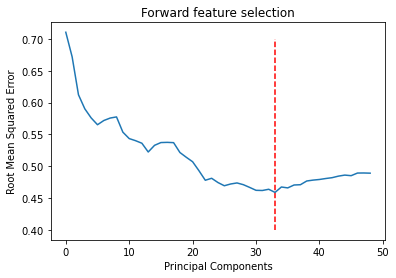

In [28]:
# Plotting the mean squared error of the models against the number of features in the model
plt.plot(results)
plt.title('Forward feature selection')
plt.xlabel('Principal Components')
plt.ylabel('Root Mean Squared Error')
plt.vlines(33, 0.4, 0.7, colors = 'r', linestyle = 'dashed')
plt.savefig('Forward selection.png', dpi = 300, bbox_inches='tight')

# 7: Linear Regression Model

From the plot above, we can see that using the mean squared error goes down until around 32 pca components are used, and from then on it stays about the same, even starting to increase again, so we will use 32 pca components for our linear regression model.

In [29]:
# Build step forward feature selection
n = 34
sfs2 = sfs(regr, n_features_to_select=n, direction="forward", cv=5)

# Perform SFFS
sfs2 = sfs2.fit(X_reduced_train, y_train)
#print(sfs1.get_support())

regr.fit(X_reduced_train[:,sfs2.get_support()], y_train)
pred = regr.predict(X_reduced_test[:,sfs2.get_support()])
print(f"The root mean squared error for our model with {n} features is {np.sqrt(mean_squared_error(y_test, pred))} \n")

# Show the model's prediction vs real value of the first 10 test pictures
for i in range(10):
    print(f"For picture {i}: predicted {pred[i]} and real answer is {y_test[i]}")

The root mean squared error for our model with 34 features is 0.45891270758987135 

For picture 0: predicted [-0.06131149] and real answer is [0.90589017]
For picture 1: predicted [-0.10039503] and real answer is [-0.19806352]
For picture 2: predicted [0.89194175] and real answer is [0.84155802]
For picture 3: predicted [0.94183933] and real answer is [0.84759983]
For picture 4: predicted [0.69423182] and real answer is [0.87869037]
For picture 5: predicted [-0.34351534] and real answer is [-0.02036865]
For picture 6: predicted [-0.15405023] and real answer is [-0.34426135]
For picture 7: predicted [0.6860674] and real answer is [0.88853368]
For picture 8: predicted [0.56407036] and real answer is [0.86311279]
For picture 9: predicted [-0.61969349] and real answer is [-0.04441033]


# 8: Generate samples

In [30]:
S2 = pca.fit_transform(X_train.T)[:,:num_features]
S2.shape

(120000, 79)

In [76]:
xs = []
indexValues = [-1.5, -1, -0.5, 0, 0.5, 1, 1.5]
for i in indexValues:
    alpha = (i - np.sum(regr.intercept_)) / np.sum(abs(regr.coef_))
    x = alpha*regr.coef_
    xs.append(x)

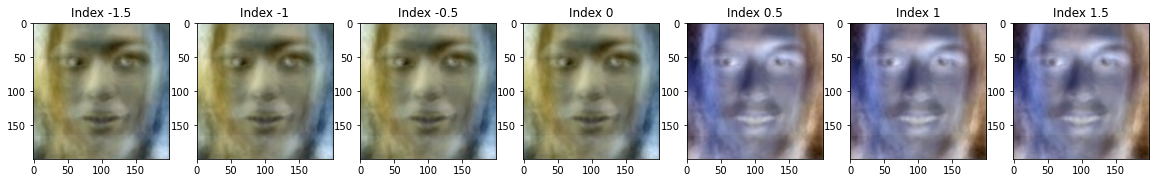

In [77]:
fig = plt.figure(figsize=(20,10))
columns = 7
rows = 1
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img = (xs[i] @ S2[:,sfs2.get_support()].T).reshape([200,200,3])
    img = (img-np.amin(img)) / (np.amax(img)-np.amin(img))
    plt.imshow(img)
    plt.title('Index '+str(indexValues[i]))
plt.show()
fig.savefig('Synthetic faces regression.png', dpi = 650, bbox_inches='tight')

# 9 Constructing continuum without reaction times

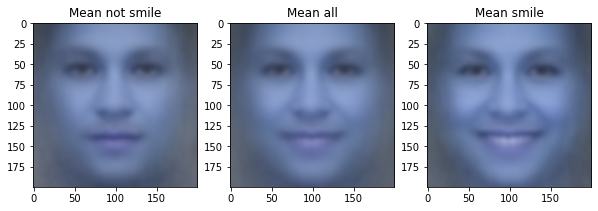

In [34]:
#Generating continuum of faces based on only the pixel-values
score_matrix = np.hstack((X,y))

# Dividing into the two classes based on score
score_matrix_smile = score_matrix[score_matrix[:,-1] > 0.5]
score_matrix_not_smile = score_matrix[score_matrix[:,-1] <= 0.5]

# Removing the last columns containing the scores 
score_matrix_smile_new = np.delete(score_matrix_smile,-1,1)
score_matrix_not_smile_new = np.delete(score_matrix_not_smile,-1,1)
score_matrix_new = np.delete(score_matrix,-1,1)

# Finding mean from not smile class
fig = plt.figure(figsize=(10,7))
mean_not_smile = np.mean(score_matrix_not_smile_new,0)
mean_not_smile_img = mean_not_smile.reshape([200,200,3])
plt.subplot(1,3,1)
plt.imshow(mean_not_smile_img/255)
plt.title('Mean not smile')

# Finding overall mean
mean_all = np.mean(score_matrix_new,0)
mean_all_img = mean_all.reshape([200,200,3])
plt.subplot(1,3,2)
plt.imshow(mean_all_img/255)
plt.title('Mean all')

# Finding the mean images from smile class
mean_smile = np.mean(score_matrix_smile_new,0)
mean_smile_img = mean_smile.reshape([200,200,3])
plt.subplot(1,3,3)
plt.imshow(mean_smile_img/255)
plt.title('Mean smile')

fig.savefig('Continuum.png', dpi = 650, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


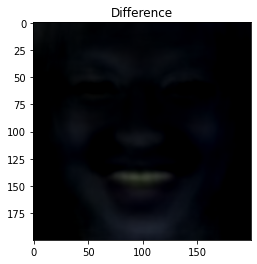

In [35]:
difference = mean_smile - mean_not_smile
difference_img = difference.reshape([200,200,3])
fig = plt.figure(figsize=(5,4))
plt.imshow(difference_img/255)
plt.title('Difference')
fig.savefig('Difference.png', dpi = 650, bbox_inches='tight')

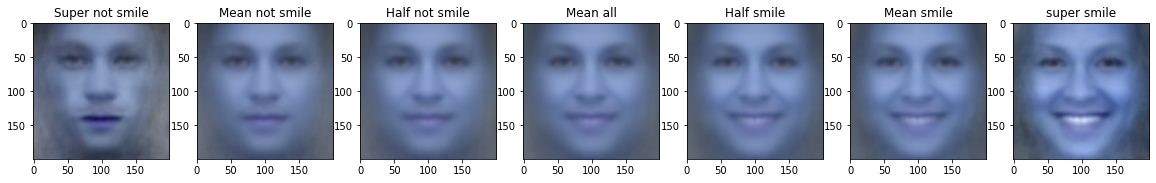

In [38]:
super_not_smile = mean_not_smile - difference
super_not_smile_img = super_not_smile.reshape([200,200,3])
fig = plt.figure(figsize=(20,10))
plt.subplot(1,7,1)
plt.imshow(super_not_smile_img/255)
plt.title('Super not smile')

plt.subplot(1,7,2)
plt.imshow(mean_not_smile_img/255)
plt.title('Mean not smile')

half_not_smile = mean_not_smile + difference/4
half_not_smile_img = half_not_smile.reshape([200,200,3])
plt.subplot(1,7,3)
plt.imshow(half_not_smile_img/255)
plt.title('Half not smile')

plt.subplot(1,7,4)
plt.imshow(mean_all_img/255)
plt.title('Mean all')

half_smile = mean_smile - difference/4
half_smile_img = half_smile.reshape([200,200,3])
plt.subplot(1,7,5)
plt.imshow(half_smile_img/255)
plt.title('Half smile')

plt.subplot(1,7,6)
plt.imshow(mean_smile_img/255)
plt.title('Mean smile')

super_smile = mean_smile + 0.95*difference
super_smile_img = super_smile.reshape([200,200,3])
plt.subplot(1,7,7)
plt.imshow(super_smile_img/255)
plt.title('super smile')

fig.savefig('7 point continuum.png', dpi = 650, bbox_inches='tight')

In [54]:
print(f"From section 6 we know that {num_features} PCA components are required to explain 90% of the variance")

# Create PCA which explains 90% variance
pca_90 = PCA(num_features)
X_pca = pca_90.fit_transform(X)

# Recreate the images using the PCA components
X_proj = pca_90.inverse_transform(X_pca)

From section 6 we know that 79 PCA components are required to explain 90% of the variance


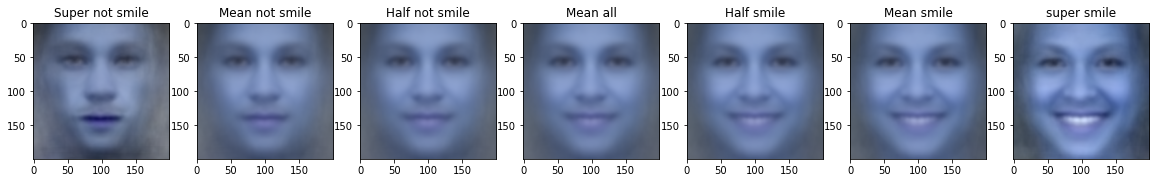

In [55]:
#Generating continuum of faces based on only the pixel-values
proj_score_matrix = np.hstack((X_proj,y))

# Dividing into the two classes based on score
proj_score_matrix_smile = proj_score_matrix[proj_score_matrix[:,-1] > 0.5]
proj_score_matrix_not_smile = proj_score_matrix[proj_score_matrix[:,-1] <= 0.5]

# Removing the last columns containing the scores 
proj_score_matrix_smile_new = np.delete(proj_score_matrix_smile,-1,1)
proj_score_matrix_not_smile_new = np.delete(proj_score_matrix_not_smile,-1,1)
proj_score_matrix_new = np.delete(proj_score_matrix,-1,1)

# Finding the mean images from smile class
proj_mean_smile = np.mean(proj_score_matrix_smile_new,0)
proj_mean_smile_img = proj_mean_smile.reshape([200,200,3])

# Finding overall mean
proj_mean_all = np.mean(proj_score_matrix_new,0)
proj_mean_all_img = proj_mean_all.reshape([200,200,3])

# Finding mean from not smile class
proj_mean_not_smile = np.mean(proj_score_matrix_not_smile_new,0)
proj_mean_not_smile_img = proj_mean_not_smile.reshape([200,200,3])

# Finding the difference
proj_difference = proj_mean_smile - proj_mean_not_smile

# Plotting images
proj_super_not_smile = proj_mean_not_smile - proj_difference
proj_super_not_smile_img = proj_super_not_smile.reshape([200,200,3])
fig = plt.figure(figsize=(20,10))
plt.subplot(1,7,1)
plt.imshow(proj_super_not_smile_img/255)
plt.title('Super not smile')

plt.subplot(1,7,2)
plt.imshow(proj_mean_not_smile_img/255)
plt.title('Mean not smile')

proj_half_not_smile = proj_mean_not_smile + proj_difference/4
proj_half_not_smile_img = proj_half_not_smile.reshape([200,200,3])
plt.subplot(1,7,3)
plt.imshow(proj_half_not_smile_img/255)
plt.title('Half not smile')

plt.subplot(1,7,4)
plt.imshow(proj_mean_all_img/255)
plt.title('Mean all')

proj_half_smile = proj_mean_smile - proj_difference/4
proj_half_smile_img = proj_half_smile.reshape([200,200,3])
plt.subplot(1,7,5)
plt.imshow(proj_half_smile_img/255)
plt.title('Half smile')

plt.subplot(1,7,6)
plt.imshow(proj_mean_smile_img/255)
plt.title('Mean smile')

proj_super_smile = proj_mean_smile + 0.95*proj_difference
proj_super_smile_img = proj_super_smile.reshape([200,200,3])
plt.subplot(1,7,7)
plt.imshow(proj_super_smile_img/255)
plt.title('super smile')

fig.savefig('pca 7 point continuum.png', dpi = 650, bbox_inches='tight')

# 10: Second experiment

First we will turn all 21 generated photos into .png files and send them to a folder called "GeneratedPhotos". We will then run the edited Matlab script to get the scores from different people. We will then load the data into a pandas dataframe and then show the results.

In [56]:
# Create lists of the images and their names
names_LinearModel = ["GeneratedPhotos\LinearModel1.png", "GeneratedPhotos\LinearModel2.png",
                     "GeneratedPhotos\LinearModel3.png", "GeneratedPhotos\LinearModel4.png",
                     "GeneratedPhotos\LinearModel5.png", "GeneratedPhotos\LinearModel6.png",
                     "GeneratedPhotos\LinearModel7.png",]
names_NoReactionTimes = ["GeneratedPhotos\\noRT1.png", "GeneratedPhotos\\noRT2.png", 
                         "GeneratedPhotos\\noRT3.png", "GeneratedPhotos\\noRT4.png", 
                         "GeneratedPhotos\\noRT5.png", "GeneratedPhotos\\noRT6.png", 
                         "GeneratedPhotos\\noRT7.png"]
names_NoReactionTimesPCA = ["GeneratedPhotos\PCAnoRT1.png", "GeneratedPhotos\PCAnoRT2.png", 
                            "GeneratedPhotos\PCAnoRT3.png", "GeneratedPhotos\PCAnoRT4.png", 
                            "GeneratedPhotos\PCAnoRT5.png", "GeneratedPhotos\PCAnoRT6.png", 
                            "GeneratedPhotos\PCAnoRT7.png"]
NoReactionTimes_images = [super_not_smile_img/255, mean_not_smile_img/255, half_not_smile_img/255, mean_all_img/255,
                         half_smile_img/255, mean_smile_img/255, super_smile_img/255]
NoReactionTimesPCA_images = [proj_super_not_smile_img/255, proj_mean_not_smile_img/255, proj_half_not_smile_img/255, 
                             proj_mean_all_img/255, proj_half_smile_img/255, proj_mean_smile_img/255, 
                             proj_super_smile_img/255]

# Save the images to files
for i in range(7):
    fig = plt.figure(figsize=(7,5))
    img = (xs[i] @ S2[:,sfs2.get_support()].T).reshape([200,200,3])
    img = (img-np.amin(img)) / (np.amax(img)-np.amin(img))
    plt.imsave(names_LinearModel[i],img)
    plt.close(fig)
    
    fig = plt.figure(figsize=(7,5))
    plt.imsave(names_NoReactionTimes[i],NoReactionTimes_images[i])
    plt.close(fig)
    
    fig = plt.figure(figsize=(7,5))
    plt.imsave(names_NoReactionTimesPCA[i],NoReactionTimesPCA_images[i])
    plt.close(fig)

In [57]:
# Loading the data into a pandas dataframe
df3 = pd.read_csv('smileResults.txt')
df3.columns = ['id', 'num', 'image', 'score']
df3.drop(["num"], axis=1, inplace=True)

df3.head()

,id,image,score
0,0,LinearModel3.png,2
1,0,noRT2.png,1
2,0,PCAnoRT4.png,3
3,0,LinearModel7.png,4
4,0,noRT3.png,1


In [58]:
# Create a new dataframe
photo_names = [str(file).split('\\')[1] for file in glob.glob("GeneratedPhotos/*.png")]
df4 = pd.DataFrame(photo_names)
df4.columns = (["image"])

# Add the scores for each person to the dataframe
count = 1
for i in df3.groupby("id"):
    grouped_df = i[1][["image","score"]]
    grouped_df.columns = ['image', 'score'+str(count)]
    df4 = pd.merge(df4, grouped_df,how="left", on=["image"])
    count += 1
    
# Take the average score
df4['average'] = df4.mean(numeric_only=True, axis=1)

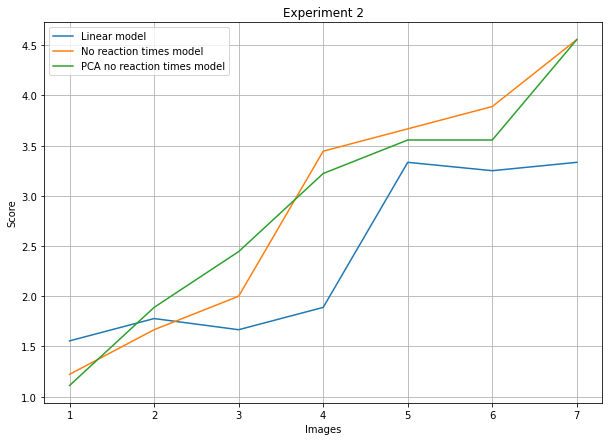

In [59]:
fig, ax = plt.subplots(figsize=(10,6))
plt.grid()
for i in range(3):
    plt.plot(range(1,8), df4['average'][i*7:(i+1)*7])
# Diagonal line
plt.axline([1, 1], [7, 5], linestyle=':', color = 'magenta', linewidth = 3.)
# Labels
plt.title('Experiment 2')
plt.ylabel('Rating')
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(['Not Smiling', r'Mean Not Smiling', r'Mean all', r'Mean Smiling', r'Smiling'])
plt.xlabel('Images from the Synthetic Continua')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(['Image 1', r'Image 2', r'Image 3', r'Image 4', r'Image 5', r'Image 6', r'Image 7'])
plt.legend(["Linear model", "No reaction times model", "PCA no reaction times model", 'Ideal linear model'])

fig.savefig('Experiment 2.png', dpi = 650, bbox_inches='tight')